In [1]:
import pickle
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib

import sys
sys.path.insert(0, '../../../')
import DLDMD as dl
import LossDLDMD as lf

%matplotlib inline

In [2]:
# Figure parameters
plot_save_path = './analysis_results/'
font = {'family': 'DejaVu Sans', 'size': 18}
matplotlib.rc('font', **font)
fontsize = 18
figsize = (15, 10)
dpisave = 300

# Initialize the compute device
DEVICE = '/GPU:0'
GPUS = tf.config.experimental.list_physical_devices('GPU')
if GPUS:
    try:
        for gpu in GPUS:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
else:
    DEVICE = '/CPU:0'

tf.keras.backend.set_floatx('float64')
print("TensorFlow version: {}".format(tf.__version__))
print("Eager execution: {}".format(tf.executing_eagerly()))
print("Num GPUs available: {}".format(len(GPUS)))
print("Running on device: {}".format(DEVICE))

TensorFlow version: 2.7.0
Eager execution: True
Num GPUs available: 0
Running on device: /CPU:0


In [3]:
# SET THIS PATH (w/o file extension!). Both '.pkl' and '.h5' files should have same name
model_path = './lorenz_2023-01-18-0049/epoch_100_loss_0.487'
model_hyp_params = model_path + '.pkl'
model_weights = model_path + '.h5'

# Load the hyper parameters
hyp_params = pickle.load(open(model_hyp_params, 'rb'))

# Set Tensorflow backend precision
tf.keras.backend.set_floatx(hyp_params['precision'])
print("Using precision: {}\n".format(tf.keras.backend.floatx()))

# Load test data
test_data = pickle.load(open('data_test.pkl', 'rb'))
print("Test data shape: {}".format(test_data.shape))

Using precision: float64

Test data shape: (2000, 600, 3)


In [4]:
# Fix hyper parameters for running the model on test data
hyp_params['pretrain'] = False
hyp_params['batch_size'] = test_data.shape[0]

# Load the trained DLDMD model weights
model = dl.DLDMD(hyp_params)
model(test_data)
model.load_weights(model_weights)

# Initialize the loss function
loss = lf.LossDLDMD(hyp_params)
print("Number of prediction steps: ", model.num_time_steps - model.num_recon_steps)

Number of prediction steps:  20


In [5]:
with tf.device(DEVICE):
    preds = model(test_data, training=False)
    losses = loss(preds, test_data)

[y, x_ae, x_adv, y_adv, weights, evals, evecs, phi] = preds
print("Loss: {loss:2.7f}".format(loss=losses.numpy()))
print("Log10 Loss: {loss:2.7f}".format(loss=np.log10(losses.numpy())))

Loss: 2.4668908
Log10 Loss: 0.3921499


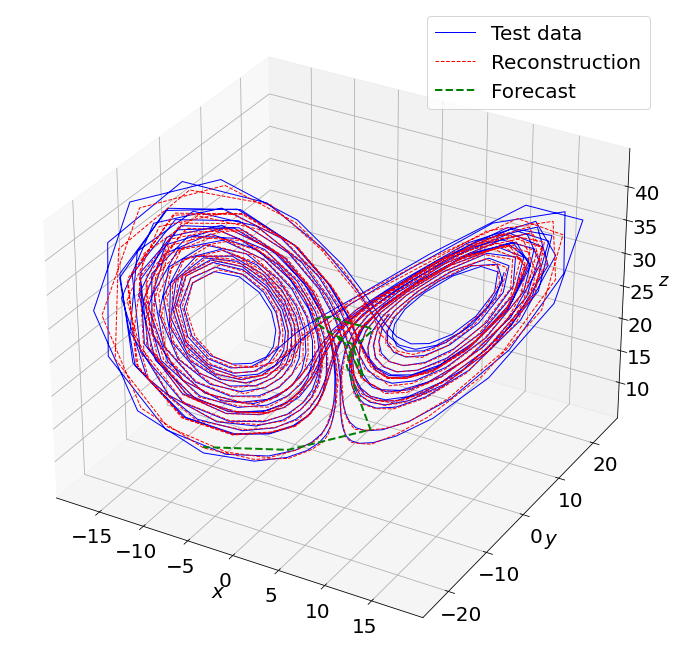

In [6]:
fs = 20
ts = 20
lw = 1
ms = 1000
figsize = (12, 12)
skip = 1

# DLDMD reconstruction
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(1, figsize=figsize,facecolor='white')
ax = fig.add_subplot(1, 1, 1, projection='3d')
ax.plot3D(test_data[0, :, 0], test_data[0, :, 1], test_data[0, :, 2], 'b', linestyle='solid', lw=lw, label='Test data')
ax.plot3D(x_adv[0, :-19, 0], x_adv[0, :-19, 1], x_adv[0, :-19, 2], 'r', linestyle='dashed', lw=lw, label='Reconstruction')
ax.plot3D(x_adv[0, -20:, 0], x_adv[0, -20:, 1], x_adv[0, -20:, 2], 'g', linestyle='dashed', lw=2*lw, label='Forecast')
plt.xlabel(r'$x$', fontsize=fs)
plt.ylabel(r'$\dot{x}$', fontsize=fs)
plt.legend(fontsize=fs, loc='upper right')
#plt.axis('equal')
ax = plt.gca()
ax.tick_params(axis='both', which='major', labelsize=ts)
ax.tick_params(axis='both', which='minor', labelsize=ts)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
ax.set_zlabel('$z$')

plt.show()
fig.savefig("dldmd_test_lorenz_63_pplane", dpi=dpisave)

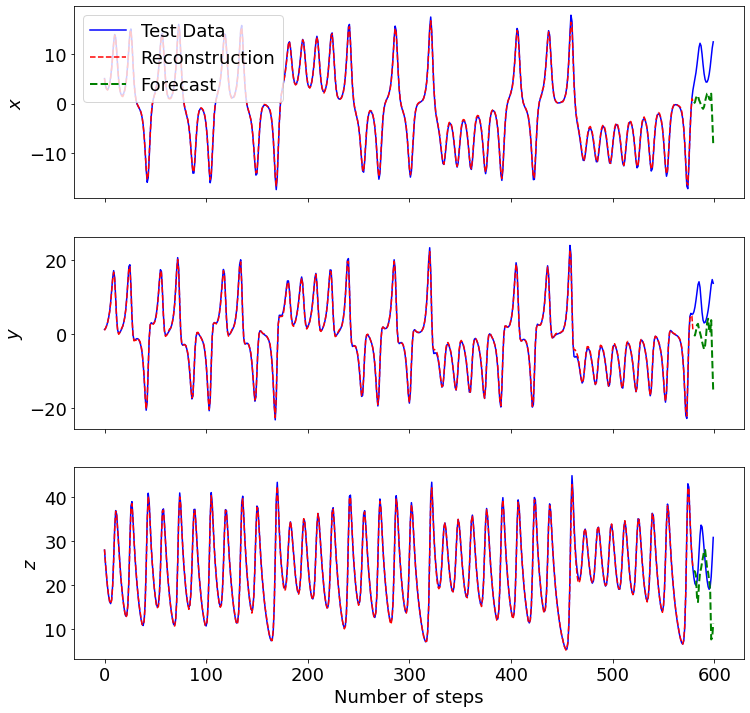

In [10]:
fig, axes = plt.subplots(3, 1, sharex=True, figsize=figsize,facecolor='white')
num_steps = range(hyp_params['num_time_steps'])
num_steps_1 =range(hyp_params['num_time_steps'] - 20)
num_steps_2 =np.arange(580,600,1)

axes[0].plot(num_steps,test_data[0, :, 0],'b',linestyle='solid',label = 'Test Data')
axes[0].plot(num_steps_1,x_adv[0,:-20,0],'r',linestyle='dashed',label = 'Reconstruction')
axes[0].plot(num_steps_2,x_adv[0,-20:,0],'g',linestyle='dashed',lw = 2*lw,label = 'Forecast')
axes[0].set_ylabel('$x$')
axes[0].legend(loc = 'upper left')

axes[1].plot(num_steps,test_data[0, :, 1],'b',linestyle='solid',label = 'Test Data')
axes[1].plot(num_steps_1,x_adv[0,:-20,1],'r',linestyle='dashed',label = 'Reconstruction')
axes[1].plot(num_steps_2,x_adv[0,-20:,1],'g',linestyle='dashed',lw = 2*lw,label = 'Forecast')
axes[1].set_ylabel('$y$')
#axes[1].legend(loc = 'upper left')


axes[2].plot(num_steps,test_data[0, :, 2],'b',linestyle='solid',label = 'Test Data')
axes[2].plot(num_steps_1,x_adv[0,:-20,2],'r',linestyle='dashed',label = 'Reconstruction')
axes[2].plot(num_steps_2,x_adv[0,-20:,2],'g',linestyle='dashed',lw = 2*lw,label = 'Forecast')
axes[2].set_ylabel('$z$')
axes[2].set_xlabel('Number of steps')
#axes[2].legend(loc = 'upper left')

fig.savefig("dldmd_test_lorenz63_xyz_over_num_steps", dpi=dpisave)

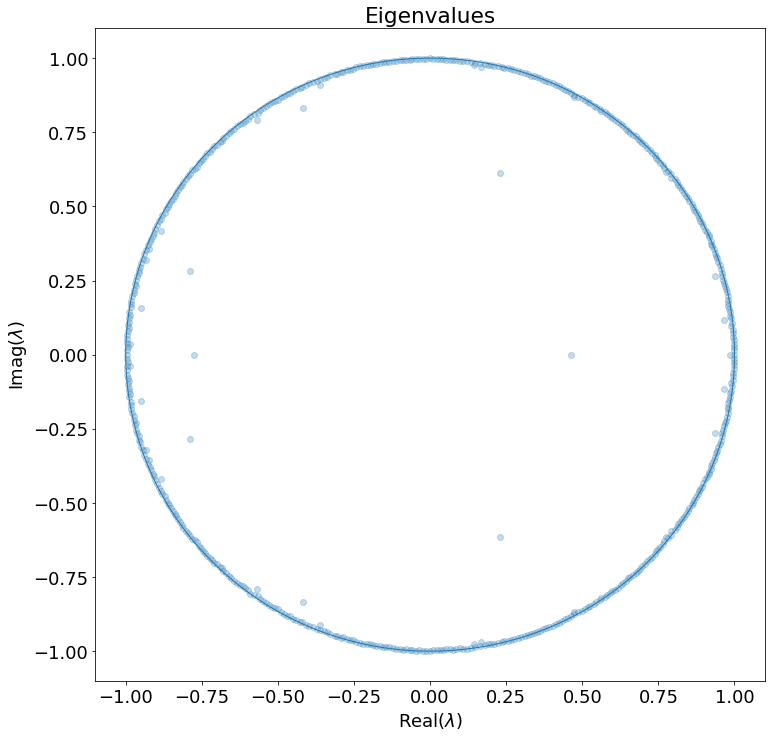

In [8]:
#Eigenvalues
fig = plt.figure(figsize=figsize,facecolor='white')
ax = fig.add_subplot(111)
t = np.linspace(0, 2*np.pi, 300)
ax.plot(np.cos(t), np.sin(t), linewidth=1)
ax.scatter(np.real(evals), np.imag(evals),alpha = 0.25)
ax.set_xlabel("Real$(\lambda)$")
ax.set_ylabel("Imag$(\lambda)$")
ax.set_title("Eigenvalues")
fig.savefig("dldmd_test_lorenz_63_evals", dpi=dpisave)